# 0. Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [4]:
np.random.seed(2510)
torch.manual_seed(2510)
torch.cuda.manual_seed(2510)

# 1. Dataset and Dataloader

In [5]:
to_tensor = transforms.ToTensor()

class BinarySegmentInferenceDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = to_tensor(image)
        return image

In [6]:
dir_path = os.path.join('..', 'images')

In [7]:
image_list = os.listdir(dir_path)
image_list

['1.png', '2.png', '3.png']

In [8]:
images = [np.array(Image.open(f'{dir_path}/{i}')) for i in image_list]

In [9]:
dataset = BinarySegmentInferenceDataset(images)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# 2. Model 

In [10]:
from torchvision.models.segmentation import deeplabv3_resnet50 

def make_binary_deeplab():
    model = deeplabv3_resnet50()
    # replace final conv to output 1 channel (original deeplabv3 outputs 21 channel, here we're only differentiating foreground from background)
    model.classifier[-1] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)
    model.aux_classifier = None
    return model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = make_binary_deeplab()
model.load_state_dict(torch.load('../model/best_model.pth', map_location=device))
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# 4. Inference

## 4.1 Inference Function

In [12]:
def inference(dataloader, model):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)['out']
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > 0.5).float()  # Binarize the output
            preds.extend(outputs.cpu().numpy().transpose(0, 2, 3, 1))
    return preds

## 4.2 Inference Collect

In [13]:
pred_pairs = pd.DataFrame(
    {
        'Image': images,
        'Prediction': inference(dataloader, model)
    }
)

## 4.2 Display

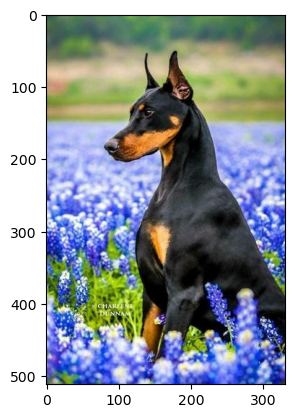

In [14]:
plt.imshow(pred_pairs.loc[2, 'Image'])

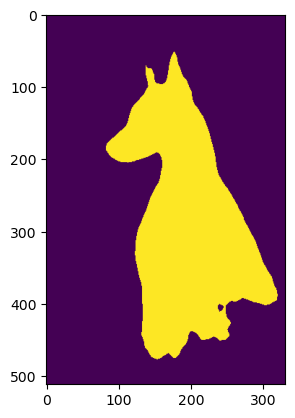

In [15]:
plt.imshow(pred_pairs.loc[2, 'Prediction'])

In [16]:
pred_pairs.loc[2, 'Image'].shape

(512, 331, 3)

In [17]:
image = cv2.imread(f'{dir_path}/{image_list[2]}')

image.shape

(512, 331, 3)

# 5. Downstream Application

## 5.1 Background Remover

In [20]:
def save_foreground(image, mask, output_path, threshold = 0.5):
    alpha = (mask > threshold).astype(np.uint8) * 255

    rgba = np.dstack((image, alpha))

    image = Image.fromarray(rgba)
    image.save(output_path, "PNG")

    return image

In [21]:
example_result = save_foreground(pred_pairs.loc[0, 'Image'], pred_pairs.loc[0, 'Prediction'], '../outputs/output.png', 0.5)

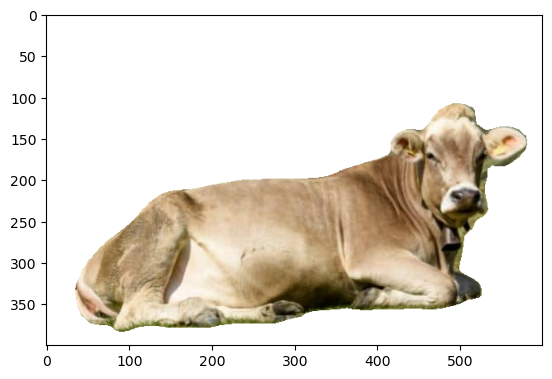

In [22]:
plt.imshow(example_result)